## So this is me redoing a project we had at General Assembly (to predict house prices using the Ames Dataset.)  Before, I had a simple model that predicted with an r-squared of ~0.84 in a train test split, which, hey, that's not bad.  There were all kinds of problems with the project though.  The notebook was a terrible mess / not commented well / a lot more could have been done. I also believe this time we can reach a higher accuracy as well.

## The goal of this notebook is to maximize the predictive model's accuracy.  Not necessarily to deeply understand the data.  I'm going to import and clean the data for sure, but beyond that there are libraries these days that are just too good.

## edit:  At a point I remembered about TPOT, a library that uses a genetic algo and automates much of the data science workflow as outlined here:

### https://github.com/EpistasisLab/tpot/blob/master/images/tpot-ml-pipeline.png

## and so I definitely could have jumped ship and let TPOT take over earlier in this process, but the work I did definitely cut the amount of combinations TPOT needed to look at.

### edit2: In the end, we train/test split and had a best r-squared of ~0.92.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

In [2]:
#import data
df = pd.read_csv("housing.csv")

In [3]:
df.MasVnrArea.isnull().sum()

8

In [4]:
for i in df.MasVnrArea:
    if math.isnan(i):
        print(i,True)

nan True
nan True
nan True
nan True
nan True
nan True
nan True
nan True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Well, the first thing to do if we're going to make a model to predict house prices is make sure we're dealing with residential buildings.

In [6]:
#From data description.txt:

#A	Agriculture
#C	Commercial
#FV	Floating Village Residential
#I	Industrial
#RH	Residential High Density
#RL	Residential Low Density
#RP	Residential Low Density Park 
#RM	Residential Medium Density

In [7]:
#looks like Residential Low Density Park is also empty anyways.
df[df["MSZoning"]=="RP"].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [8]:
nonResidential = ["A","C","I"]

In [9]:
for i in nonResidential:
    df = df[df["MSZoning"]!=i]

In [10]:
#Ah, looks like C (all) snuck past us.
df["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [11]:
df = df[df["MSZoning"]!="C (all)"]

In [12]:
df["MSZoning"].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

### Alright so now we're working with the right types of buildings.

### Next, If a column has more than 80% missing data, I'm going to flag it and probably end up deciding to get rid of it.

In [13]:
 moreThan80PercentGone = []
for i in df.columns:
    if sum(df[i].isnull())/len(df) > 0.8:
        moreThan80PercentGone.append(i)

In [14]:
moreThan80PercentGone

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [15]:
df[moreThan80PercentGone].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 4 columns):
Alley          89 non-null object
PoolQC         7 non-null object
Fence          278 non-null object
MiscFeature    52 non-null object
dtypes: object(4)
memory usage: 56.6+ KB


### Fence is the only thing that looks remotely salvagable.  If the value is nan, I'll replace it with "noInfo" -- we may end up eventually just dropping this column.

In [16]:
df["Fence"].value_counts()

MnPrv    155
GdPrv     59
GdWo      53
MnWw      11
Name: Fence, dtype: int64

In [17]:
replacementList = []
for i in df["Fence"]:
    if type(i) != str:
        replacementList.append("noInfo")
    else:
        replacementList.append(i)
#print(replacementList)
df["Fence"] = replacementList

In [18]:
df["Fence"].value_counts()

noInfo    1172
MnPrv      155
GdPrv       59
GdWo        53
MnWw        11
Name: Fence, dtype: int64

In [19]:
moreThan80PercentGone = []
for i in df.columns:
    if sum(df[i].isnull())/len(df) > 0.8:
        moreThan80PercentGone.append(i)

In [20]:
moreThan80PercentGone

['Alley', 'PoolQC', 'MiscFeature']

### I'm just dropping these other columns as they're virtually non-existent.

In [21]:
for i in moreThan80PercentGone:
    df = df.drop(i,axis=1)

### Next, I still want to see what other columns have incomplete data and in what way.

In [22]:
Incomplete = []
for i in df.columns:
    if sum(df[i].isnull())/len(df) != 0:
        Incomplete.append(i)

In [23]:
print(Incomplete)

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


In [24]:
# fig, ax = plt.subplots(figsize=(16,48)) 
# sns.heatmap(df[Incomplete].isnull(),ax=ax)
# plt.show()

### Unfortunately, we don't have a nice situation where certain rows are largely responsible for all of the missingness (aside from how it appears that if you don't have one piece of basement info, you don't get any other piece of basement info.)   I think we'll have to address these on a case-by-case basis.

In [25]:
df[Incomplete].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 15 columns):
LotFrontage     1191 non-null float64
MasVnrType      1442 non-null object
MasVnrArea      1442 non-null float64
BsmtQual        1413 non-null object
BsmtCond        1413 non-null object
BsmtExposure    1412 non-null object
BsmtFinType1    1413 non-null object
BsmtFinType2    1412 non-null object
Electrical      1449 non-null object
FireplaceQu     769 non-null object
GarageType      1371 non-null object
GarageYrBlt     1371 non-null float64
GarageFinish    1371 non-null object
GarageQual      1371 non-null object
GarageCond      1371 non-null object
dtypes: float64(3), object(12)
memory usage: 181.2+ KB


### Well there's something more clear.  There's perfect consistency with the missing Garage data, near-perfect with the Basement, and also perfect with Masonry Veneer.   We'll start with the Garage.

In [26]:
df["GarageType"].value_counts()

Attchd     870
Detchd     381
BuiltIn     88
Basment     18
CarPort      8
2Types       6
Name: GarageType, dtype: int64

### I'm going to go ahead and say the missing data is actually "None" (meaning no garage exists), and honestly, it doesn't matter what it's called, seeing how the way any model interprets these categories, they might as well be labeled 0 through 6.

### Also of note, feature engineering a column that is just 1 (if garage exists) and 0 (if garage doesn't exist) may be a valuable move.

### For now I'm just going to replace the nulls with "None".

In [27]:
# for i in df.columns:
#     print(df[[i]].dtypes[0])

In [28]:
def replaceNullsWithValue(theDf,theColumn):
    ''' do this to fix the null issue in your data for object columns :
    df[theColumn] = replaceNullsWithValue(df,theColumn)
    as this function will return a list that will replace the old list
    and have the null values replaced.
    
    this function will just crash if it runs into a dtype it isn't prepared for,
    and this is by design to avoid any silent errors.
    '''
    rnwv = []
    columnType = theDf[[theColumn]].dtypes[0]
    if columnType == 'O':
        daType = str
        replacement = "None"
    elif columnType == 'int64' or columnType == 'int32' or columnType == 'int8':
        daType = int
        replacement = 0
    elif columnType == 'float64':
        daType = float
        replacement = 0
    for i in theDf[theColumn]:
        if daType != float:
            if type(i) != daType:
                rnwv.append(replacement)
            else:
                rnwv.append(i)
        else:
            if math.isnan(i):
                rnwv.append(replacement)
            else:
                rnwv.append(i)
    return rnwv

In [29]:
garageColumns = []
for i in Incomplete:
    if "Garage" in i:
        garageColumns.append(i)

In [30]:
garageColumns

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

In [31]:
for i in garageColumns:
    df[i] = replaceNullsWithValue(df,i)

In [32]:
df[garageColumns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 5 columns):
GarageType      1450 non-null object
GarageYrBlt     1450 non-null float64
GarageFinish    1450 non-null object
GarageQual      1450 non-null object
GarageCond      1450 non-null object
dtypes: float64(1), object(4)
memory usage: 68.0+ KB


### There.  No null values for the Garage columns.  Now I wasted space there as far as converting integer columns to object columns, but 1) that can be fixed later by writing a function that converts all categories to integers if need be.  2) There's such a limited amount of data that it doesn't even matter.  It's not taking up any space anyways.

In [33]:
df["GarageType"].value_counts()

Attchd     870
Detchd     381
BuiltIn     88
None        79
Basment     18
CarPort      8
2Types       6
Name: GarageType, dtype: int64

### Since there's so much consistentcy between the columns also in Bsmt and MasVnr, I'm going to do the same with those.

In [34]:
theOthers = []
for i in Incomplete:
    if "Bsmt" in i or "MasVnr" in i:
        theOthers.append(i)

In [35]:
theOthers

['MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2']

In [36]:
for i in theOthers:
    df[i] = replaceNullsWithValue(df,i)

In [37]:
df[theOthers].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 7 columns):
MasVnrType      1450 non-null object
MasVnrArea      1450 non-null float64
BsmtQual        1450 non-null object
BsmtCond        1450 non-null object
BsmtExposure    1450 non-null object
BsmtFinType1    1450 non-null object
BsmtFinType2    1450 non-null object
dtypes: float64(1), object(6)
memory usage: 90.6+ KB


### Let's see what else is left from "Incomplete"

In [38]:
Incomplete = []
for i in df.columns:
    if sum(df[i].isnull())/len(df) != 0:
        Incomplete.append(i)

In [39]:
Incomplete

['LotFrontage', 'Electrical', 'FireplaceQu']

In [40]:
df[Incomplete].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 3 columns):
LotFrontage    1191 non-null float64
Electrical     1449 non-null object
FireplaceQu    769 non-null object
dtypes: float64(1), object(2)
memory usage: 45.3+ KB


### Okay Electrical is literally missing one value.

In [41]:
df["Electrical"].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [42]:
df["Electrical"] = replaceNullsWithValue(df,"Electrical")

In [43]:
df["Electrical"].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
None        1
Name: Electrical, dtype: int64

### Electrical seems like another column that might benefit from converting it to something like 1 (SBrkr) and 0 (Else)  (or to be honest just dropping the column, seeing how 1328/1450 are in one category.)  We'll see.

In [44]:
df[["LotFrontage"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 1 columns):
LotFrontage    1191 non-null float64
dtypes: float64(1)
memory usage: 22.7 KB


### Ah, right LotFrontage would be floats.

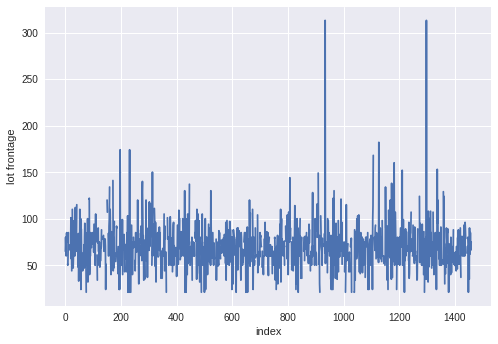

In [45]:
plt.plot(df["LotFrontage"])
plt.xlabel("index")
plt.ylabel("lot frontage")

In [46]:
print(min(df["LotFrontage"]))
print(max(df["LotFrontage"]))

21.0
313.0


### So LotFrontage is easily the hardest column to deal with so far.  It has a fair amount of variance and, at least to me, it isn't clear what the lack of information means.  I'm not at all comfortable subbing in 0 for the missing values.  

### Also those couple outliers should be removed later if we keep this column.

### Before we get all crazy, let's see if this column even matters.

In [47]:
df[["LotFrontage","SalePrice"]].corr() #this automatically will not use the missing values in the calculation,
# so that's not an issue.

,LotFrontage,SalePrice
LotFrontage,1.000000,0.354848
SalePrice,0.354848,1.000000


In [48]:
dfLFReplaceWithZero = df.copy()

In [49]:
rpl = []
for i in dfLFReplaceWithZero["LotFrontage"]:
    if i > 20:
        rpl.append(i)
    else:
        rpl.append(0)
dfLFReplaceWithZero["LotFrontage"] = rpl

In [50]:
dfLFReplaceWithZero[["LotFrontage","SalePrice"]].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.214273
SalePrice,0.214273,1.000000


### Well I mean that's enough for me --  It's definitely an important column.  There's a lot of correlation when we only use the good values, and we lose an entire 14% when we just faceroll / replace with 0.  We have to find some way of imputing the missing values.

In [51]:
dfLFReplaceWithZero = 0 #freeing memory lol

In [52]:
df["FireplaceQu"].value_counts()

Gd    379
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

### Unfortunately we can't use .corr() here, but I'm sure a barplot will be fine to get the general idea.

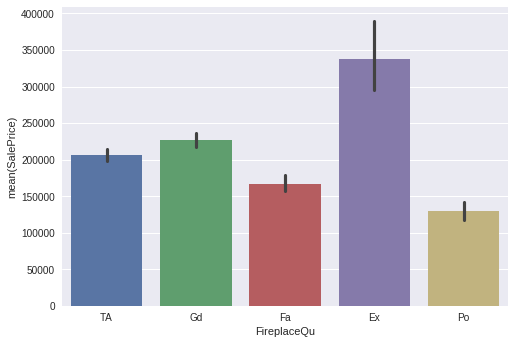

In [53]:
sns.barplot(df["FireplaceQu"],df["SalePrice"]);

### Well that's definitely enough to look into it more.

### Let's convert the missing values to "None" and see if the picture still makes sense.

In [54]:
dfNone = df.copy()

In [55]:
dfNone["FireplaceQu"] = replaceNullsWithValue(dfNone,"FireplaceQu")

In [56]:
dfNone["FireplaceQu"].value_counts()

None    681
Gd      379
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64

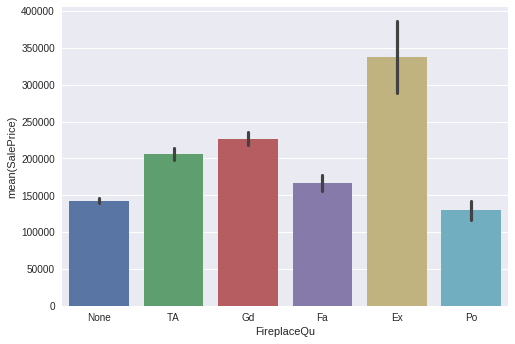

In [57]:
sns.barplot(dfNone["FireplaceQu"],dfNone["SalePrice"]);

### Yeah I mean that still looks sensible what with None being around the lowest average.

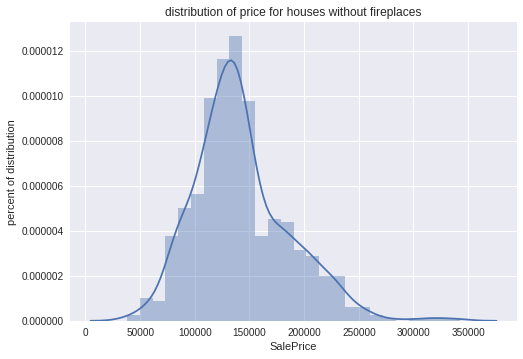

In [58]:
sns.distplot(dfNone["SalePrice"][dfNone["FireplaceQu"]=="None"]);
plt.ylabel("percent of distribution");
plt.title("distribution of price for houses without fireplaces");

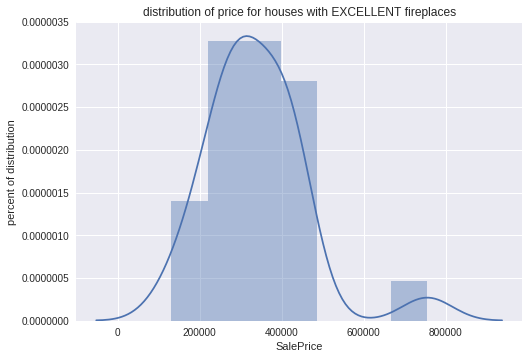

In [59]:
sns.distplot(dfNone["SalePrice"][dfNone["FireplaceQu"]=="Ex"]);
plt.ylabel("percent of distribution");
plt.title("distribution of price for houses with EXCELLENT fireplaces");

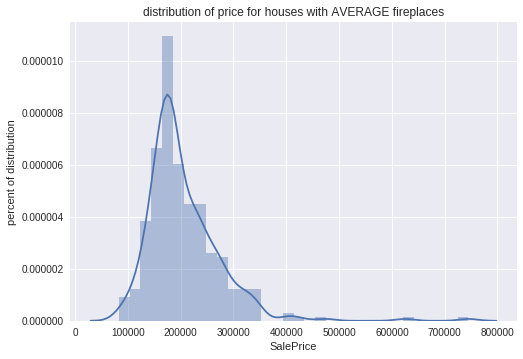

In [60]:
sns.distplot(dfNone["SalePrice"][dfNone["FireplaceQu"]=="TA"]);
plt.ylabel("percent of distribution");
plt.title("distribution of price for houses with AVERAGE fireplaces");

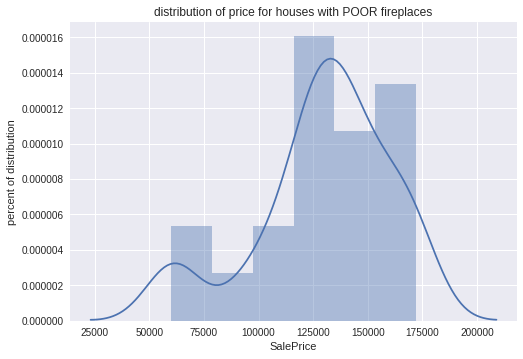

In [61]:
sns.distplot(dfNone["SalePrice"][dfNone["FireplaceQu"]=="Po"]);
plt.ylabel("percent of distribution");
plt.title("distribution of price for houses with POOR fireplaces");

### I'm content with what we're seeing here.  It does appear that if you have a fireplace, and especially if it's a great one, that does seem to be an indicator... The column probably matters at least a little bit and so at least initially the column will be included until proven to be a distraction.  I'll include the column with "None" replacing the missing values.

In [62]:
df["FireplaceQu"] = replaceNullsWithValue(df,"FireplaceQu")

#

### This nearly concludes the section where I clean up the null values, but we are left with the LotFrontage problem. 

### Our first task, unexpectedly, will be to train a model to predict LotFrontage.

### First, I'm just going to see if we can use RandomForestClassifier's feature importances to reduce our own time investigating things.  After all, this is only to salvage one column.

### Also of note, we'll be keeping SalePrice in but not predicting with it in the end -- the reason I'm keeping it in has to do with restructuring the DataFrame later.

In [63]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [64]:
X = df.copy()
#X = X.drop("SalePrice",axis=1)
X = X.drop("Id",axis=1)

In [65]:
def keyer(theDf,theColumn):
    '''returns a new column to replace the old one, where the
    strings that represented different categories are replaced with 
    unique integer values (increasing)'''
    kyr = []
    seen = {}
    counter = 0
    for i in theDf[theColumn]:
        try:
            kyr.append(seen[i])
        except:
            seen[i] = counter
            kyr.append(seen[i])
            counter += 1
    return kyr

In [66]:
for i in X.columns:
    if type(X[i][0]) == str:
        X[i] = keyer(X,i)

In [67]:
X["FireplaceQu"].value_counts()

0    681
2    379
1    313
3     33
4     24
5     20
Name: FireplaceQu, dtype: int64

In [68]:
X_impute = X[X["LotFrontage"].isnull()==True].drop("LotFrontage",axis=1)

In [69]:
y_impute = X[X["LotFrontage"].isnull()==True]["LotFrontage"]

In [70]:
X_main = X[X["LotFrontage"].isnull()==False].drop("LotFrontage",axis=1)

In [71]:
y_main = X[X["LotFrontage"].isnull()==False]["LotFrontage"]

In [72]:
#X.info()

In [73]:
rfr = RandomForestRegressor()

kf_shuffle = KFold(n_splits=4,shuffle=True,random_state=42)
scores = cross_val_score(rfr, X_main, y_main, cv=kf_shuffle)

print("scores",scores)
print("np.mean(scores)",np.mean(scores))
print("np.std(scores)",np.std(scores))

scores [ 0.4829173   0.3459856   0.4256949   0.47140517]
np.mean(scores) 0.431500740642
np.std(scores) 0.053811182916


### Not bad at all.

In [74]:
rfr.fit(X_main,y_main)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [75]:
for i in zip([x for x in X_main.columns],rfr.feature_importances_):
    if i[1] > 0.01:
        print(i)

('LotArea', 0.37580416293026264)
('LotShape', 0.023464278601511918)
('LotConfig', 0.042269785251920836)
('Neighborhood', 0.011384648001545511)
('Condition1', 0.067098138960343542)
('BldgType', 0.065037330543929836)
('YearBuilt', 0.035964926280895045)
('RoofStyle', 0.014744278152622168)
('RoofMatl', 0.022378069066007027)
('TotalBsmtSF', 0.032313813397356672)
('1stFlrSF', 0.018673146769048722)
('GrLivArea', 0.053887638264498786)
('GarageArea', 0.038084981859373403)
('SalePrice', 0.01904791085990102)


In [76]:
simplerModelColumns = []
for i in zip([x for x in X_main.columns],rfr.feature_importances_):
    if i[1] > 0.01:
        simplerModelColumns.append(i[0])

In [77]:
simplerModelColumns

['LotArea',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'YearBuilt',
 'RoofStyle',
 'RoofMatl',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'GarageArea',
 'SalePrice']

In [78]:
#simplerModelColumns.remove("MoSold")

In [79]:
X_main2 = X_main.copy()

In [80]:
X_main2 = X_main2[simplerModelColumns]

In [81]:
rfr = RandomForestRegressor()

kf_shuffle = KFold(n_splits=4,shuffle=True,random_state=42)
scores = cross_val_score(rfr, X_main2, y_main, cv=kf_shuffle)

print("scores",scores)
print("np.mean(scores)",np.mean(scores))
print("np.std(scores)",np.std(scores))

scores [ 0.52519871  0.35518756  0.52645962  0.46757286]
np.mean(scores) 0.468604684602
np.std(scores) 0.0696681178148


### Better, but a lot of variance

In [82]:
rfr = RandomForestRegressor()

kf_shuffle = KFold(n_splits=4,shuffle=True,random_state=42)
scores = cross_val_score(rfr, X_main2[["LotArea"]], y_main, cv=kf_shuffle)

print("scores",scores)
print("np.mean(scores)",np.mean(scores))
print("np.std(scores)",np.std(scores))

scores [ 0.37313547  0.23757279  0.33391752  0.0571729 ]
np.mean(scores) 0.250449669699
np.std(scores) 0.122004523253


In [83]:
rfr.fit(X_main2[simplerModelColumns],y_main)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
y_replace = rfr.predict(X_impute[simplerModelColumns])

In [85]:
y_impute = y_replace

In [86]:
yFinal = list(y_main) + list(y_impute)

In [87]:
X_testImpute = pd.concat([X_main,X_impute])

In [88]:
X_testImpute["LotFrontage"] = yFinal

### Ah, the imputation is done.  I mean I'm not going to GridSearch over columns, models, and parameters for one column that isn't even the best column.  At least not yet.

### Let's take a look at the old correlation and the new correlation with the imputed values.

In [89]:
df[["LotFrontage","SalePrice"]].corr() #old stuff

,LotFrontage,SalePrice
LotFrontage,1.000000,0.354848
SalePrice,0.354848,1.000000


In [90]:
X_testImpute[["LotFrontage","SalePrice"]].corr() #with imputed values

,LotFrontage,SalePrice
LotFrontage,1.000000,0.346703
SalePrice,0.346703,1.000000


### Bascially the same! Fantastic!

### Now I'm going to show the old untouched values and their correlation with SalePrice, and then the new imputed values and their correlation with SalePrice.

In [91]:
X_testImpute[["LotFrontage","SalePrice"]][:1191].corr() # only old values

,LotFrontage,SalePrice
LotFrontage,1.000000,0.354848
SalePrice,0.354848,1.000000


### Okay so the old values have an identical affect.  Good.  Otherwise it means we did the whole process wrong.

In [92]:
X_testImpute[["LotFrontage","SalePrice"]][1191:1450].corr() #only new imputed stuff

,LotFrontage,SalePrice
LotFrontage,1.000000,0.306182
SalePrice,0.306182,1.000000


In [94]:
print(0.306182/0.354848)

0.8628539543691948


### Amazing!  We're barely losing anything!

### Now I just have to shuffle the original df around so it's ordered in the same way, and then I can accept these new values into the LotFrontage column.

In [95]:
# X_impute = X[X["LotFrontage"].isnull()==True].drop("LotFrontage",axis=1)
# y_impute = X[X["LotFrontage"].isnull()==True]["LotFrontage"]
# X_main = X[X["LotFrontage"].isnull()==False].drop("LotFrontage",axis=1)
# y_main = X[X["LotFrontage"].isnull()==False]["LotFrontage"]

In [96]:
dfPart1 = df[df["LotFrontage"].isnull()==False]
dfPart2 = df[df["LotFrontage"].isnull()==True]

In [97]:
df2 = pd.concat([dfPart1,dfPart2])

In [98]:
df2[["LotFrontage","SalePrice"]][:].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.354848
SalePrice,0.354848,1.000000


In [99]:
df2["LotFrontage"] = X_testImpute["LotFrontage"]

In [100]:
df2[["LotFrontage","SalePrice"]][:].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.346703
SalePrice,0.346703,1.000000


In [101]:
df2[["LotFrontage","SalePrice"]][:1191].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.354848
SalePrice,0.354848,1.000000


In [102]:
df2[["LotFrontage","SalePrice"]][1191:1450].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.306182
SalePrice,0.306182,1.000000


### Okay everything checks out!

### Now I think I'm going to get rid of irrelevant columns

In [103]:
df = 0
X_testImpute = 0
X_main = 0
X_impute = 0
y_main = 0
y_impute = 0
y_replace = 0
dfPart1 = 0
dfPart2 = 0
#clearing memory

In [104]:
df2 = df2.drop("Id",axis=1)

### I'm going to write a function that flags a column whose value_counts() have 90% or more of their values as one value.  These sorts of columns should probably be dropped and for now (I can always come back), I'm going to drop them and shift to df3.

In [105]:
def flag90(theDf,theColumn):
    '''returns True if column has 90% or more of value_counts() in just one value'''
    if max(theDf[theColumn].value_counts())/len(theDf) > 0.89:
        return True
    else:
        return False

In [106]:
flagged90 = []
for i in df2.columns:
    if flag90(df2,i) == True:
        flagged90.append(i)

In [107]:
flagged90

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'BsmtCond',
 'Heating',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [108]:
df3 = df2.copy()

In [109]:
for i in flagged90:
    df3 = df3.drop(i,axis=1)

In [122]:
df4 = df3.copy() #So I can run the model a bunch of times

In [123]:
for i in df4.columns:
    if type(df4[i][0]) == str:
        df4[i] = keyer(df4,i)

### Let's see how well the remaining columns do individually at predicting SalePrice.

In [124]:
def predictiveness(theDf,target,verbose=False,splits=5):
    X_f = theDf.drop(target,axis=1)
    y_f = theDf[target]
    
    report = []
    counter = 0
    for i in X_f.columns:
        rfr_f = RandomForestRegressor()
        
        kf_shuffle = KFold(n_splits=splits,shuffle=True,random_state=42)
        scores = cross_val_score(rfr_f, X_f[[i]], y_f, cv=kf_shuffle)

        #print("scores",scores)
        #print("np.mean(scores)",np.mean(scores))
        #print("np.std(scores)",np.std(scores))
        report.append([i,np.mean(scores)])
        if verbose == True:
            counter += 1
            print(counter,"done out of",len(theDf.columns),"columns")
    return report

In [125]:
report_1 = predictiveness(df4,"SalePrice")

In [126]:
for i in report_1:
    print(i)

['MSSubClass', 0.2259896149274514]
['MSZoning', 0.089518411086622021]
['LotFrontage', 0.0098164824475384712]
['LotArea', -0.087068572469190114]
['LotShape', 0.062079475534531879]
['LotConfig', 0.0086382895397315584]
['Neighborhood', 0.52985358359033607]
['Condition1', 0.021775235411782456]
['BldgType', 0.028059579923715928]
['HouseStyle', 0.066343020302406949]
['OverallQual', 0.66637970386107437]
['OverallCond', 0.10750145935931424]
['YearBuilt', 0.31589571560741792]
['YearRemodAdd', 0.23317553654341028]
['RoofStyle', 0.04481285857496338]
['Exterior1st', 0.119737074409011]
['Exterior2nd', 0.10279292278498778]
['MasVnrType', 0.17176625033891643]
['MasVnrArea', -0.045077908897557008]
['ExterQual', 0.46211354946124272]
['ExterCond', 0.013246843386668882]
['Foundation', 0.24949556436107842]
['BsmtQual', 0.45764103147572499]
['BsmtExposure', 0.13462420551912044]
['BsmtFinType1', 0.20149892118349033]
['BsmtFinSF1', 0.026779017406115279]
['BsmtFinType2', 0.019870529378223579]
['BsmtFinSF2', -

### Actually real quick I want to see where we're at just with clean data and useless columns cut.

In [128]:
X = df4.drop("SalePrice",axis=1)
y = df4["SalePrice"]

rfr = RandomForestRegressor()
        
kf_shuffle = KFold(n_splits=4,shuffle=True,random_state=42)
scores = cross_val_score(rfr, X, y, cv=kf_shuffle)

print("scores",scores)
print("np.mean(scores)",np.mean(scores))
print("np.std(scores)",np.std(scores))

scores [ 0.80373393  0.87152903  0.85733003  0.82048714]
np.mean(scores) 0.838270031778
np.std(scores) 0.0272874419372


### Wow, we're around the score I submitted in school and all I did was impute one column really well and cut absolutely useless columns.

### Now I should use feature importances from this model and simplify.  What I'm going to do is let it run 100 times, because these are randomForests and they will have different approaches sometimes, and whatever features make it even once past the 0.01% importance treshold, these will be included in our "simpler" model.

In [150]:
importantFeatures = []
for _ in range(100):
    rfr.fit(X,y)
    for i in zip(X.columns,rfr.feature_importances_):
        if i[1] > 0.01 and i[0] not in importantFeatures:
            importantFeatures.append(i[0])

In [151]:
importantFeatures

['LotArea',
 'OverallQual',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'YearBuilt',
 'FullBath',
 'LotFrontage',
 'TotRmsAbvGrd',
 'BsmtQual',
 'GarageYrBlt',
 'MasVnrArea',
 'ExterQual',
 'KitchenQual',
 'OpenPorchSF',
 'BsmtUnfSF',
 'WoodDeckSF']

In [155]:
avgScore = []
avgStdDev = []
for i in range(10):
    rfr2 = RandomForestRegressor()

    kf_shuffle = KFold(n_splits=4,shuffle=True,random_state=42)
    scores = cross_val_score(rfr2, X[importantFeatures], y, cv=kf_shuffle)
    avgScore.append(np.mean(scores))
    avgStdDev.append(np.std(scores))
    #print("scores",scores)
    #print("np.mean(scores)",np.mean(scores))
    #print("np.std(scores)",np.std(scores))
avgScore = np.mean(avgScore)
avgStdDev = np.mean(avgStdDev)

In [157]:
print(avgScore,avgStdDev)

0.831292659786 0.0391347869365


### Well we have a much simpler model and we've retained most of the strength, so that's wonderful.  Glad to see LotFrontage made it as well!

###  Now I'd actually like to see what kind of predicting this model is doing right now.  Where is it getting tripped up?  Is there any edge we can get there?

In [160]:
rfr3 = RandomForestRegressor()
#rfr3.fit(X[importantFeatures],y)

In [162]:
X = X[importantFeatures]

In [163]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [165]:
rfr3.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [167]:
predictions = rfr3.predict(X_test)

In [180]:
offBy = abs(y_test-predictions)

(array([ 219.,   91.,   27.,   13.,    3.,    4.,    1.,    2.,    2.,    1.]),
 array([  8.00000000e+01,   1.48201100e+04,   2.95602200e+04,
          4.43003300e+04,   5.90404400e+04,   7.37805500e+04,
          8.85206600e+04,   1.03260770e+05,   1.18000880e+05,
          1.32740990e+05,   1.47481100e+05]),
 <a list of 10 Patch objects>)

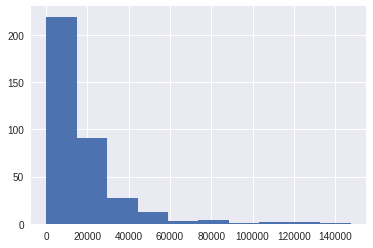

In [181]:
plt.hist(offBy)

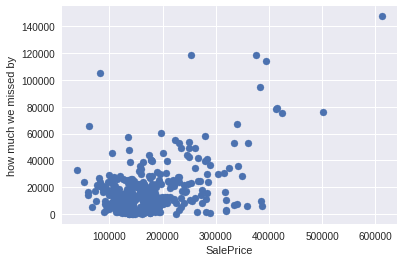

In [187]:
plt.scatter(y_test,offBy);
plt.xlabel("SalePrice");
plt.ylabel("how much we missed by");

### Ah, the higher the price, the more off we are, and the higher it gets, the fewer the values.  We need to be predicting log price.

In [189]:
y2 = [math.log(x) for x in y]

In [220]:
rfr4 = RandomForestRegressor()

kf_shuffle = KFold(n_splits=4,shuffle=True,random_state=42)
scores = cross_val_score(rfr4, X, y2, cv=kf_shuffle)

print("scores",scores)
print("np.mean(scores)",np.mean(scores))
print("np.std(scores)",np.std(scores))

scores [ 0.81416322  0.84787705  0.85595935  0.87738976]
np.mean(scores) 0.848847344315
np.std(scores) 0.02274411924


### There we go.  Much less variance too.

### All you need to do to get back the real predictions afterwards is math.exp() them.

### Alright, honestly I think most of the hard work has been done here.  

### TPOT is a library that handles the rest.  Data importing and cleaning is something people do, but TPOT bruteforces the other part really well and I've cut its workload down some so it doesn't take forever.  I'm not using AWS to get a higher percentage.  That really isn't the point of this notebook.  But yeah, first I'm going to let it predict regularly (not log price.)

In [311]:
from tpot import TPOTRegressor

In [312]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [313]:
rfr5 = RandomForestRegressor()

In [314]:
rfr5.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [315]:
rfr5.score(X_test,y_test)

0.81980535576818969

In [325]:
tpot_clf_1 = TPOTRegressor(scoring="r2",max_time_mins=10)

Version 0.9.0 of tpot is outdated. Version 0.9.2 was released Wednesday January 17, 2018.


In [326]:
tpot_clf_1.fit(X_train,pd.Series(y_train))

TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=1000000, max_eval_time_mins=5,
       max_time_mins=10, mutation_rate=0.9, n_jobs=1, offspring_size=100,
       periodic_checkpoint_folder=None, population_size=100,
       random_state=None, scoring=None, subsample=1.0, verbosity=0,
       warm_start=False)

In [327]:
#preds = tpot_clf_1.predict(X_test)

In [328]:
# for i in range(len(preds)):
#     print(abs(preds[i]-list(y_test)[i]))

In [329]:
tpot_clf_1.score(X_test,pd.Series(y_test))

0.86957458889924122

### Okay and now with log price

In [331]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.25)

In [332]:
tp2 = TPOTRegressor(scoring="r2",max_time_mins=10)

Version 0.9.0 of tpot is outdated. Version 0.9.2 was released Wednesday January 17, 2018.


In [333]:
tp2.fit(X_train,pd.Series(y_train))

TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=1000000, max_eval_time_mins=5,
       max_time_mins=10, mutation_rate=0.9, n_jobs=1, offspring_size=100,
       periodic_checkpoint_folder=None, population_size=100,
       random_state=None, scoring=None, subsample=1.0, verbosity=0,
       warm_start=False)

In [334]:
tp2.score(X_test,pd.Series(y_test))

0.91903131195735344

### Well okay then.  And that's TPOT running for 10 minutes on a home computer without the n_jobs parameter being increased and without training on the other 25% of the data.

### AWS/TPOT has got to be a legendary black box


### Anyhow yeah I'm going to pickle the model and reload it, and then show a couple graphs that sort of summarize where the model shines and doesn't shine.

In [353]:
import pickle as pkl

In [359]:
with open('tp2.pkl', 'wb') as f:
    pkl.dump(tp2.fitted_pipeline_, f) 

In [360]:
with open('tp2.pkl', 'rb') as f:
    tp2Load = pkl.load(f)

In [366]:
finalPredictionsOfInternalTestSplit = [math.exp(x) for x in tp2Load.predict(X_test)]

In [371]:
finalTest = [math.exp(x) for x in y_test]

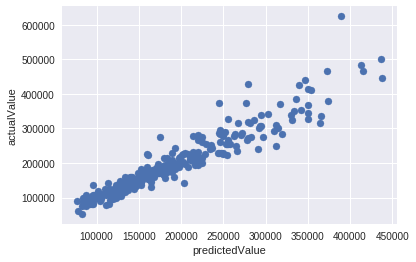

In [375]:
plt.scatter(finalPredictionsOfInternalTestSplit,finalTest);
plt.xlabel("predictedValue");
plt.ylabel("actualValue");

In [377]:
finalAbsDiff = [abs(x-y) for x,y in zip(finalPredictionsOfInternalTestSplit,finalTest)]

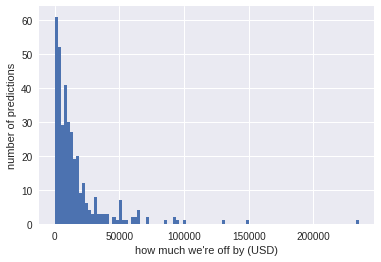

In [382]:
plt.hist(finalAbsDiff,bins=100);
plt.xlabel("how much we're off by (USD)");
plt.ylabel("number of predictions");

### I think the nutshell about this model and everything is that it's good at predicting houses as long as they're cheap and not great at predicting them when they're expensive, even despite the log price pseudofix, and I don't think that's particularly weird either, because we didn't have a lot of costly houses in the dataset, and it's also a relatively small dataset as far as len(df) goes.